In [1]:
from typing import Dict, List
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
!pip install peptidy
import peptidy

In [2]:
seq1 = pd.read_csv('/content/CMP sequences with labels.csv')

In [3]:
seq1

,Sequence,Label
0,YGNNNNGY,0
1,PKEPKEGR,0
2,PKEPKEGE,1
3,YGKEKEGY,0
4,YGSSSSGY,0
...,...,...
95,ERERERERER,0
96,PRPRPRPRPR,0
97,SRSRSRSRSR,1
98,KGLLYRGGHG,0


In [ ]:
X=seq1.drop('Label',axis=1)
y=seq1['Label']

In [ ]:
# Only select the active peptides
active_peptides = X["Sequence"][y==1].tolist()
pad_len = max([len(peptide) for peptide in active_peptides]) + 2        # +2 for start and end tokens

n_training = 17

training_peptides = active_peptides[:n_training]
val_peptides = active_peptides[n_training:]

In [ ]:
class PeptideLoader(torch.utils.data.Dataset):
    def __init__(
        self,
        label_encoded_peptides: torch.LongTensor,
    ):
        self.label_encoded_peptides = label_encoded_peptides

    def __len__(self):
        return self.label_encoded_peptides.shape[0]

    def __getitem__(self, idx):
        peptide = self.label_encoded_peptides[idx, :]
        X = peptide[:-1]
        y = peptide[1:]
        return X, y


def tokenize_peptides(
    peptides: List[str],
    padding_length: int,
) -> torch.LongTensor:
    token_to_label = peptidy.biology.token_to_label
    tokenized_peptides = [peptidy.encoding.label_encoding(peptide, padding_len=padding_length, add_generative_tokens=True) for peptide in peptides]

    return torch.LongTensor(tokenized_peptides), token_to_label

def get_dataloader(
    peptides: List[str],
    padding_length: int,
    batch_size: int,
    shuffle: bool = True,
):
    peptides_tensor, token_to_label = tokenize_peptides(peptides, padding_length)

    return torch.utils.data.DataLoader(
        PeptideLoader(peptides_tensor),
        batch_size=batch_size,
        shuffle=shuffle,
    )

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        model_dim: int,
        n_layers: int,
        vocab_size: int,
        sequence_length: int,
        learning_rate: float,
        n_epochs: int,
        batch_size: int,
        device: str,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.model_dim = model_dim
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.device = device

        self.architecture = self.build_architecture()

    def build_architecture(self):
        return nn.ModuleDict(
            dict(
                embedding = nn.Embedding(self.vocab_size, self.model_dim, padding_idx=0),
                lstm = nn.LSTM(self.model_dim, self.model_dim, self.n_layers, batch_first=True),
                lm_head = nn.Linear(self.model_dim, self.vocab_size),
            )
        )

    def forward(
        self,
        x: torch.LongTensor,
        hidden_states: torch.FloatTensor = None,
        training: bool = True,
    ):
        if len(x.shape) == 1:
            x = x.unsqueeze(1)                                      # (batch_size, 1, seq_len)
        x = self.architecture.embedding(x)                          # (batch_size, seq_len, model_dim)
        x, hidden_states = self.architecture.lstm(x, hidden_states) # (batch_size, seq_len, model_dim)
        x = self.architecture.lm_head(x)                            # (batch_size, seq_len, vocab_size)
        if training:
            return x

        return x, hidden_states

    def __compute_loss(
        self,
        inputs: torch.LongTensor,
        targets: torch.LongTensor,
    ) -> torch.Tensor:
        logits = self.forward(inputs, training=True)
        logits = logits.permute(0, 2, 1)
        return F.cross_entropy(logits, targets.long())

    def fit(
        self,
        training_peptides: List[str],
        val_peptides: List[str],
    ):

        self = self.to(self.device)
        self.train()

        train_dataloader = get_dataloader(training_peptides, self.sequence_length, self.batch_size)
        val_dataloader = get_dataloader(val_peptides, self.sequence_length, self.batch_size)

        optimizer = torch.optim.Adam(self.parameters(), self.learning_rate)
        history = {"train_loss": list(), "val_loss": list()}

        for epoch_ix in range(self.n_epochs):
            self.train()

            n_train_samples, epoch_train_loss = 0, 0
            for X_train, y_train in train_dataloader:
                X_train, y_train = X_train.to(self.device), y_train.to(self.device)
                n_train_samples += X_train.shape[0]

                optimizer.zero_grad()
                batch_train_loss = self.__compute_loss(X_train, y_train)
                batch_train_loss.backward()
                optimizer.step()

                epoch_train_loss += batch_train_loss.item() * X_train.shape[0]

            epoch_train_loss = epoch_train_loss / n_train_samples
            history["train_loss"].append(epoch_train_loss)

            self.eval()
            n_val_samples, epoch_val_loss = 0, 0
            for X_val, y_val in val_dataloader:
                X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                n_val_samples += X_val.shape[0]

                batch_val_loss = self.__compute_loss(X_val, y_val)
                epoch_val_loss += batch_val_loss.item() * X_val.shape[0]

            epoch_val_loss = epoch_val_loss / n_val_samples
            history["val_loss"].append(epoch_val_loss)
            print(f"Epoch {epoch_ix} | Train loss: {epoch_train_loss} | Val loss: {epoch_val_loss}")

        return history

    def initialize_hidden_states(self, batch_size: int):
        return (
            torch.zeros(self.n_layers, batch_size, self.model_dim)
            .float()
            .to(self.device),
            torch.zeros(self.n_layers, batch_size, self.model_dim)
            .float()
            .to(self.device),
        )


    def design_peptides(
        self,
        n_batches: int,
        batch_size: int,
        temperature: float,
        sequence_length: int,
        token_to_label: Dict[str, int],
        begin_token: str,
        end_token: str,
    ):
        self = self.to(self.device)
        self.eval()
        label_to_token = {v: k for k,v in token_to_label.items()}
        designs = list()

        for _ in range(n_batches):
            hidden_states = self.initialize_hidden_states(batch_size)
            current_token = torch.zeros(
                batch_size,
            )
            current_token = token_to_label[begin_token] + current_token.long().to(self.device)

            batch_designs = list()
            for __ in range(sequence_length - 1):
                preds, hidden_states = self.forward(current_token, hidden_states, training=False)
                preds = preds.squeeze(1)
                preds = preds / temperature
                probs = F.softmax(preds, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
                batch_designs.append(next_token)

                current_token = next_token

            batch_designs = torch.vstack(batch_designs).T
            designs.append(batch_designs)

        designs = torch.cat(designs, dim=0).cpu().numpy().tolist()
        end_index = token_to_label[end_token]
        designs = [
            design[ : design.index(end_index)] if end_index in design else ""
            for design in designs
        ]

        final_designs = list()
        for design in designs:
            if design == "":
                final_designs.append("")
            else:
                final_designs.append("".join([label_to_token[label] for label in design]))

        return final_designs

In [ ]:
print(f"Number of training samples: {len(training_peptides)}")
print(f"Number of validation samples: {len(val_peptides)}")

Number of training samples: 17
Number of validation samples: 16


Epoch 0 | Train loss: 3.463697910308838 | Val loss: 3.20271635055542
Epoch 1 | Train loss: 3.191140651702881 | Val loss: 2.567211389541626
Epoch 2 | Train loss: 2.545008897781372 | Val loss: 2.4828076362609863
Epoch 3 | Train loss: 2.5515360832214355 | Val loss: 2.364083766937256
Epoch 4 | Train loss: 2.3142802715301514 | Val loss: 2.239624261856079
Epoch 5 | Train loss: 2.117809295654297 | Val loss: 2.0934646129608154
Epoch 6 | Train loss: 1.9691425561904907 | Val loss: 2.005364418029785
Epoch 7 | Train loss: 1.8215371370315552 | Val loss: 1.989924669265747
Epoch 8 | Train loss: 1.7128608226776123 | Val loss: 1.9646985530853271
Epoch 9 | Train loss: 1.5924358367919922 | Val loss: 1.9694100618362427
Epoch 10 | Train loss: 1.486337661743164 | Val loss: 2.022902011871338
Epoch 11 | Train loss: 1.4177334308624268 | Val loss: 2.0404441356658936
Epoch 12 | Train loss: 1.361749291419983 | Val loss: 2.136996269226074
Epoch 13 | Train loss: 1.2623136043548584 | Val loss: 2.185976505279541
Epoc

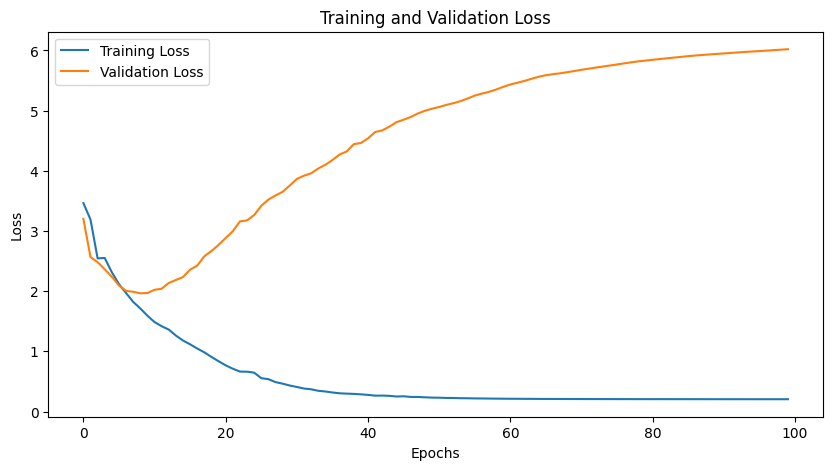

In [ ]:
# Retrieve token_to_label dictionary from peptidy
token_to_label = peptidy.biology.token_to_label

# Define model parameters
model_dim = 156
n_layers = 2
vocab_size = len(token_to_label) + 3                # +3 for start, end, and padding tokens
learning_rate = 0.01
n_epochs = 100
batch_size = 32

# Create model
lstm = LSTM(model_dim, n_layers, vocab_size, pad_len, learning_rate, n_epochs, batch_size, "cpu")

# Fit model
history = lstm.fit(training_peptides, val_peptides)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Designs:
['', 'FQDFNDFADA', 'KEGSSVVVVV', 'FQDFNDFADA', 'KEGSSVVVVV', '', 'YTRDLLYKNP', 'RRFGFGFGRR', 'GADGVGKSAL', 'PKEPKEGE', 'GADGVGKSAV', 'RGFGGDGWGG', 'DGYGGGAGWA', 'RRFGFGFGRR', 'YGGPRPRPRPR', 'RGFGGDGWGG', 'GHGLYGRGLK', 'KEGSSVVVVV', 'GHGLYRGKGG', 'YGGPRPRPRPR', 'RRFGFGFGRR', 'FQDFNDFADA', 'SRLKKFDFWS', 'PKEPKEGE', '', '', 'RGFGGDGWGG', 'SRLKKFDFWS', 'YTRDLVYKNP', 'RRFGFGFGRR', '', 'GHGLYRGKGG', 'GADGVGKSAL', 'YTRDLVYKNP', '', 'RRFGFGFGRR', 'SRLKKFDFWS', 'DGYGGGAGWA', 'DGYGGGAGWA', 'YYYGGNNNNN', 'RGFGGDGWGG', '', 'PKEPKEGE', 'RGRWGGIIIII', 'PKEPKEGE', 'GADGVGKSAL', 'GADGVGKSAL', 'PKEPKEGE', '', 'RGWGGIIII', '', 'KEGSSVVVVV', 'GADGVGKSAL', 'GHGLYRGKGG', 'GHGLYGRGLK', 'KEGSSVVVVV', 'RRFGFGFGRR', 'RGRWGGIIIII', 'YTRDLVYKNP', 'GHGLYGRGLK', 'RGRWGGIIIII', '', 'YTRDLVYKNP', 'YYYGGNNNNN', 'GHGLYRGKGG', 'YYYGGNNNNN', '', 'GADGVGKSAL', 'KEGSSVVVVV', 'YGGPRPRPRPR', '', 'SRLKKFDFWS', 'YYYGGNNNNN', 'DGYGGGAGWA', 'KEGSSVVVVV', '', 'GHGLYRGKGG', 'KEGSSVVVVV', '', 'KEGSSVVVVV', 'KEGSSVVVV', 'S

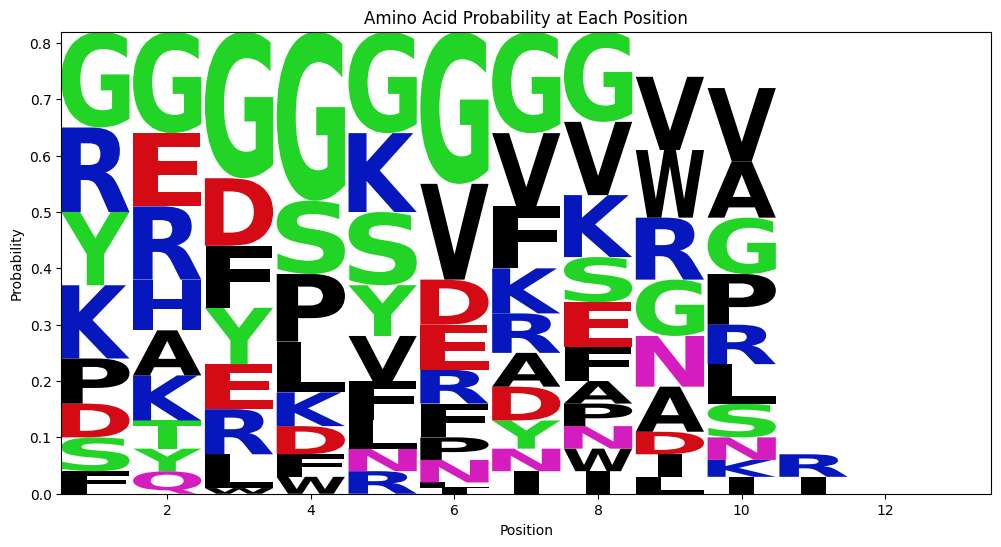

In [ ]:
import peptidy
import numpy as np
!pip install logomaker
import logomaker
import matplotlib.pyplot as plt

# Provided parameters
n_batches = 10
batch_size = 10
temperature = 1.2
sequence_length = 13

token_to_label = peptidy.biology.token_to_label.copy()
token_to_label["<PAD>"] = 0
token_to_label["<BEG>"] = len(token_to_label)
token_to_label["<END>"] = len(token_to_label)


# Generate peptide designs
designs = lstm.design_peptides(n_batches, batch_size, temperature, sequence_length, token_to_label, begin_token="<BEG>", end_token="<END>")
print("Designs:")
print(designs)

# Calculate the probabilities of each amino acid at each position
max_length = 13  # Fixed length
amino_acids = list(peptidy.biology.token_to_label.keys())
amino_acid_count = {aa: [0]*max_length for aa in amino_acids}

for seq in designs:
    for i, token in enumerate(seq[:max_length]):  # Truncate sequences to max_length
        if token in amino_acid_count:
            amino_acid_count[token][i] += 1


print("Amino acid count:")
for aa, counts in amino_acid_count.items():
    print(f"{aa}: {counts}")

# Convert counts to probabilities
probabilities = {aa: [count/len(designs) for count in counts] for aa, counts in amino_acid_count.items()}
print("Probabilities:")
for aa, probs in probabilities.items():
    print(f"{aa}: {probs}")

# Create a DataFrame suitable for logomaker
# Rows as positions (numeric), columns as amino acids
positions = list(range(1, max_length + 1))
logo_df = pd.DataFrame(0.0, index=positions, columns=amino_acids)  # Initialize with 0.0 to ensure numeric

for aa in amino_acids:
    for i in range(max_length):
        logo_df.at[positions[i], aa] = probabilities[aa][i]

# Ensure all values are numeric
logo_df = logo_df.astype(float)
logo_df1 =logo_df.drop(columns=['S_p', 'T_p','Y_p', 'C_m', 'R_m', 'R_d', 'R_s', 'K_a'])

print("Logo DataFrame:")
print(logo_df1)

# Plot the sequence logo
fig, ax = plt.subplots(figsize=(12, 6))
logomaker.Logo(logo_df1, ax=ax)

ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title('Amino Acid Probability at Each Position')

plt.show()